## Importing necessary Libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import datetime

In [2]:
df_train_relevant = pd.read_csv('train_modified.csv')

In [3]:
# Type conversion

df_train_relevant['HourlyRelativeHumidity'] = df_train_relevant.HourlyRelativeHumidity.astype(float)
df_train_relevant['HourlyDewPointTemperature'] = df_train_relevant.HourlyDewPointTemperature.astype(float)
df_train_relevant['HourlyDryBulbTemperature'] = df_train_relevant.HourlyDryBulbTemperature.astype(float)
df_train_relevant['Target'] = df_train_relevant.Target.astype(float)
df_train_relevant['HourlyWindSpeed'] = df_train_relevant.HourlyWindSpeed.astype(float)
df_train_relevant['HourlyWindDirection'] = df_train_relevant.HourlyWindDirection.astype(float)
df_train_relevant['HourlySeaLevelPressure'] = df_train_relevant.HourlySeaLevelPressure.astype(float)

# df_train_relevant.dtypes

## Walkthrough for city of Agra !!

In [4]:
city = "AGRA, IN"

df_train_city = df_train_relevant[df_train_relevant['NAME'] == city].reset_index(drop = True)

## Date-time sorting:
df_train_city.sort_values(by=['Date', 'Time'],inplace = True)

df_train_city.reset_index(drop=True,inplace = True)

# dropping unneessary features
df_city = df_train_city.drop(['STATION','NAME','ELEVATION','LATITUDE','LONGITUDE'],axis=1)


In [5]:
df_city

,Unnamed: 0,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed,HourlyWindDirection,HourlySeaLevelPressure,Target,Date,Time
0,495478,77.0,89.0,68.0,8.0,203.0,29.96,2.49,1942-08-24,14:30:00
1,353497,77.0,90.0,66.0,5.0,158.0,29.96,2.49,1942-08-24,15:30:00
2,126946,81.0,89.0,78.0,5.0,113.0,29.95,2.49,1942-08-24,16:30:00
3,427116,77.0,89.0,68.0,3.0,180.0,29.95,1.24,1942-08-24,17:30:00
4,475875,79.0,84.0,85.0,0.0,0.0,29.63,2.49,1942-08-25,08:30:00
...,...,...,...,...,...,...,...,...,...,...
73528,392533,55.0,67.0,65.0,2.0,160.0,30.04,2.49,2020-12-13,11:30:00
73529,254824,50.0,50.0,100.0,2.0,199.0,30.11,2.49,2020-12-16,05:30:00
73530,26944,47.0,72.0,42.0,3.0,20.0,29.96,6.21,2020-12-24,14:30:00
73531,444299,56.0,57.0,96.0,3.0,20.0,29.98,2.49,2021-01-05,05:30:00


In [6]:
# Mean w.r.t Date

# Anomaly -- Don't know Run below command if dtype of 'Target' is object

# df_city['Target'] = df_city.Target.astype(float)

df_city = df_city.groupby('Date',as_index=False).mean()


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

<Figure size 1152x1152 with 0 Axes>

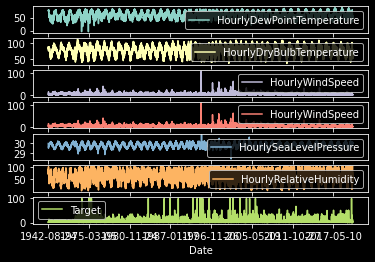

In [268]:
fig = plt.figure(figsize=(16,16))
plt.style.use("dark_background")
df_city.set_index("Date")[["HourlyDewPointTemperature", "HourlyDryBulbTemperature","HourlyWindSpeed", "HourlyWindSpeed", "HourlySeaLevelPressure", "HourlyRelativeHumidity", "Target"]].plot(subplots = True)

## Feature Engineering

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

In [8]:
df_city[["HourlyDewPointTemperature"]].shape, df_city[["HourlyDryBulbTemperature"]].shape, df_city[["HourlyRelativeHumidity"]].shape, df_city[["Target"]].shape, df_city[["HourlyWindSpeed"]].shape, df_city[["HourlyWindDirection"]].shape, df_city[["HourlySeaLevelPressure"]].shape

((14946, 1),
 (14946, 1),
 (14946, 1),
 (14946, 1),
 (14946, 1),
 (14946, 1),
 (14946, 1))

In [9]:
import datetime

df_city_N = df_city[855:]

HourlyWindDirection = [df_city_N["HourlyWindDirection"].iloc[0]]
HourlyDewPointTemperature = [df_city_N["HourlyDewPointTemperature"].iloc[0]]
HourlyDryBulbTemperature = [df_city_N["HourlyDryBulbTemperature"].iloc[0]]
HourlyRelativeHumidity = [df_city_N["HourlyRelativeHumidity"].iloc[0]]
HourlyWindSpeed = [df_city_N["HourlyWindSpeed"].iloc[0]]
HourlySeaLevelPressure = [df_city_N["HourlySeaLevelPressure"].iloc[0]]
Target = [df_city_N["Target"].iloc[0]]

first = df_city_N["Date"].iloc[0]
last = df_city_N["Date"].iloc[-1]

first = datetime.datetime.fromisoformat(first).date()
last = datetime.datetime.fromisoformat(last).date()

cur_date = first

index = 1
while index < len(df_city_N["Date"]):
    cur_date = df_city_N["Date"].iloc[index]
    prev_date = df_city_N["Date"].iloc[index-1]
    cur_date = datetime.datetime.fromisoformat(cur_date).date()
    prev_date = datetime.datetime.fromisoformat(prev_date).date()
    if (cur_date - prev_date).days == 1:
        HourlyWindDirection.append(df_city_N["HourlyWindDirection"].iloc[index])
        HourlyDewPointTemperature.append(df_city_N["HourlyDewPointTemperature"].iloc[index])
        HourlyDryBulbTemperature.append(df_city_N["HourlyDryBulbTemperature"].iloc[index])
        HourlyRelativeHumidity.append(df_city_N["HourlyRelativeHumidity"].iloc[index])
        HourlyWindSpeed.append(df_city_N["HourlyWindSpeed"].iloc[index])
        HourlySeaLevelPressure.append(df_city_N["HourlySeaLevelPressure"].iloc[index])
        Target.append(df_city_N["Target"].iloc[index])
    else:
        for date in range((cur_date-prev_date).days):
            replace_value = (df_city_N["HourlyWindDirection"].iloc[index] + df_city_N["HourlyWindDirection"].iloc[index-1])/2
            HourlyWindDirection.append(replace_value)
            replace_value = (df_city_N["HourlyDewPointTemperature"].iloc[index] + df_city_N["HourlyDewPointTemperature"].iloc[index-1])/2
            HourlyDewPointTemperature.append(replace_value)
            replace_value = (df_city_N["HourlyDryBulbTemperature"].iloc[index] + df_city_N["HourlyDryBulbTemperature"].iloc[index-1])/2
            HourlyDryBulbTemperature.append(replace_value)
            replace_value = (df_city_N["HourlyRelativeHumidity"].iloc[index] + df_city_N["HourlyRelativeHumidity"].iloc[index-1])/2
            HourlyRelativeHumidity.append(replace_value)
            replace_value = (df_city_N["HourlyWindSpeed"].iloc[index] + df_city_N["HourlyWindSpeed"].iloc[index-1])/2
            HourlyWindSpeed.append(replace_value)
            replace_value = (df_city_N["HourlySeaLevelPressure"].iloc[index] + df_city_N["HourlySeaLevelPressure"].iloc[index-1])/2
            HourlySeaLevelPressure.append(replace_value)
            replace_value = (df_city_N["Target"].iloc[index] + df_city_N["Target"].iloc[index-1])/2
            Target.append(replace_value)
    index += 1


In [10]:
first = df_city_N["Date"].iloc[0]
last = df_city_N["Date"].iloc[-1]

first = datetime.datetime.fromisoformat(first).date()
last = datetime.datetime.fromisoformat(last).date()

df_city_new = pd.DataFrame()

dates = []
for date in range((last - first).days + 1):
    dates.append(first)
    first = first + datetime.timedelta(days=1)

df_city_new["Date"] = dates
df_city_new["HourlyWindDirection"] = HourlyWindDirection
df_city_new["HourlyDewPointTemperature"] = HourlyDewPointTemperature
df_city_new["HourlyDryBulbTemperature"] = HourlyDryBulbTemperature
df_city_new["HourlyRelativeHumidity"] = HourlyRelativeHumidity
df_city_new["HourlyWindSpeed"] = HourlyWindSpeed
df_city_new["HourlySeaLevelPressure"] = HourlySeaLevelPressure
df_city_new["Target"] = Target

In [11]:
df_city_new

,Date,HourlyWindDirection,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyRelativeHumidity,HourlyWindSpeed,HourlySeaLevelPressure,Target
0,1944-12-31,324.200000,43.150000,58.100000,60.050000,9.300000,30.007000,3.107000
1,1945-01-01,243.052632,48.263158,54.736842,80.368421,6.000000,30.053684,2.796842
2,1945-01-02,261.347826,42.086957,51.608696,74.304348,4.956522,30.051739,2.019565
3,1945-01-03,221.000000,40.857143,53.428571,65.285714,5.047619,29.938571,6.761429
4,1945-01-04,91.300000,46.550000,52.700000,80.200000,9.500000,29.818000,2.303000
...,...,...,...,...,...,...,...,...
27764,2021-01-05,20.000000,51.500000,64.500000,69.000000,3.000000,29.970000,4.350000
27765,2021-01-06,178.000000,55.000000,55.500000,98.000000,2.500000,29.975000,1.865000
27766,2021-01-07,178.000000,55.000000,55.500000,98.000000,2.500000,29.975000,1.865000
27767,2021-01-08,178.000000,55.000000,55.500000,98.000000,2.500000,29.975000,1.865000


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# df_input = df_city[["HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyWindSpeed", "HourlyWindDirection", "HourlySeaLevelPressure", "Target"]]

df_input = df_city_new[["HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyWindSpeed", "HourlySeaLevelPressure", "Target"]]

data_scaled = scaler.fit_transform(df_input)

features = data_scaled[:, :-1]
target = data_scaled[:, -1]

target_N = np.concatenate((np.array([target[-1]]), target))

target_N = target_N[:-1]

target_N.shape, target.shape

x_train, x_test, y_train, y_test = train_test_split(features, target_N, test_size=0.20, random_state=123, shuffle=False)

win_length = 1
batch_size = 32
num_features = 5

train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

## Training the Model --> Custom LSTM

In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            68608     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 128)            0         
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [15]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
             optimizer=tf.optimizers.Adam(),
             metrics = [tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, 
                              epochs=10,
                             validation_data=test_generator,
                             shuffle=False,)

Epoch 1/10


C:\Users\ABHISH~1\AppData\Local\Temp/ipykernel_1488/723824058.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


695/695 [==============================] - 11s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0158 - val_loss: 0.0029 - val_mean_absolute_error: 0.0272
Epoch 2/10
695/695 [==============================] - 4s 6ms/step - loss: 0.0025 - mean_absolute_error: 0.0155 - val_loss: 0.0029 - val_mean_absolute_error: 0.0265
Epoch 3/10
695/695 [==============================] - 5s 7ms/step - loss: 0.0025 - mean_absolute_error: 0.0154 - val_loss: 0.0029 - val_mean_absolute_error: 0.0261
Epoch 4/10
695/695 [==============================] - 6s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0153 - val_loss: 0.0029 - val_mean_absolute_error: 0.0256
Epoch 5/10
695/695 [==============================] - 6s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0151 - val_loss: 0.0029 - val_mean_absolute_error: 0.0261
Epoch 6/10
695/695 [==============================] - 6s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0153 - val_loss: 0.0029 - val_mean_absolute_error: 0.0259
Epoch 7/10
695/695 [======

## Inference

In [237]:
samples = np.expand_dims(x_test, axis=1)

preds = model(samples)

samples_squeezed = np.squeeze(samples)

preds_squeezed = np.squeeze(preds)

y_test_normalized = scaler.fit_transform(np.expand_dims(y_test, axis=-1))

preds_squeezed, labels

x = np.array([i for i in range(x_test.shape[0])])

Text(0.5, 1.0, 'Predicted Labels')

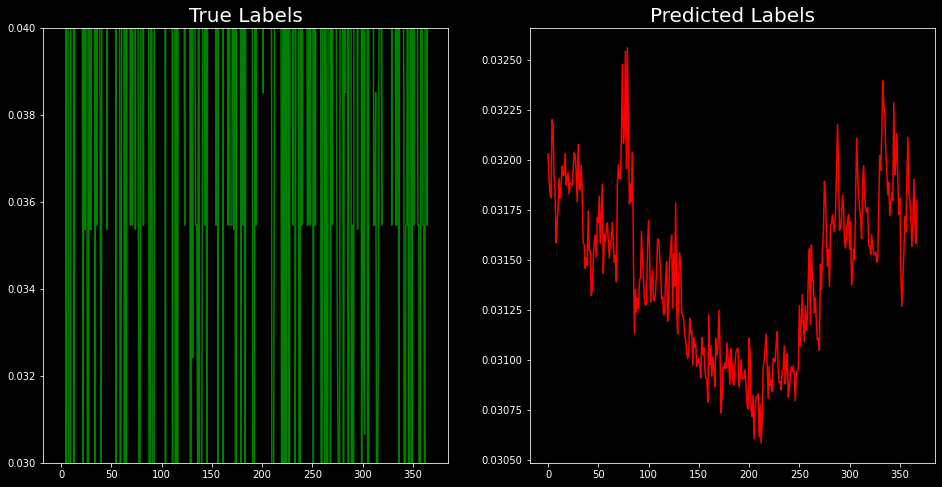

In [238]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.plot(x, preds_squeezed, color='red')
ax.set_title("Target Predictions", fontsize=20)





# **Model training for each city**





In [42]:
# taking into account "number of observations" w.r.t different categories in NAME categorical feature.
make_dist  = df_train_relevant.groupby('NAME').size()
y = np.array(make_dist)
x = np.array(make_dist.keys().tolist())

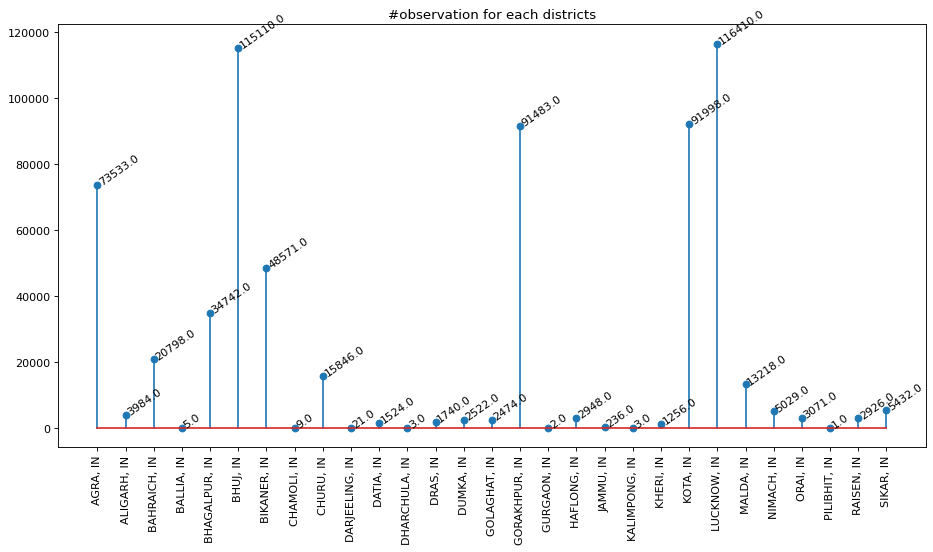

In [43]:
## distribution plot :  number of obs. w.r.t to different categories.
from matplotlib.pyplot import figure

labs = [float(i) for i in y.tolist()]
figure(figsize=(14, 7), dpi=80)
plt.stem(x,y)
plt.xticks(rotation = 'vertical')
for i, txt in enumerate(labs):
    plt.annotate(txt, (x[i], y[i]),rotation = 35)
plt.title('#observation for each districts')
plt.show()

In [278]:
cities = set(df_train_relevant["NAME"])

cities_mse = {}

In [281]:
cities

{'AGRA, IN',
 'ALIGARH, IN',
 'BAHRAICH, IN',
 'BALLIA, IN',
 'BHAGALPUR, IN',
 'BHUJ, IN',
 'BIKANER, IN',
 'CHAMOLI, IN',
 'CHURU, IN',
 'DARJEELING, IN',
 'DATIA, IN',
 'DHARCHULA, IN',
 'DRAS, IN',
 'DUMKA, IN',
 'GOLAGHAT, IN',
 'GORAKHPUR, IN',
 'GURGAON, IN',
 'HAFLONG, IN',
 'JAMMU, IN',
 'KALIMPONG, IN',
 'KHERI, IN',
 'KOTA, IN',
 'LUCKNOW, IN',
 'MALDA, IN',
 'NIMACH, IN',
 'ORAI, IN',
 'RAISEN, IN',
 'SIKAR, IN'}

In [282]:
# City wise analysis
for city in cities:
    city = city

    df_train_city = df_train_relevant[df_train_relevant['NAME'] == city].reset_index(drop = True)

    ## Date-time sorting:
    df_train_city.sort_values(by=['Date', 'Time'],inplace = True)

    df_train_city.reset_index(drop=True,inplace = True)
    
    # dropping unneessary features
    df_city = df_train_city.drop(['STATION','NAME','ELEVATION','LATITUDE','LONGITUDE'],axis=1)
    
    df_city = df_city.groupby('Date',as_index=False).mean()
    
    df_city_N = df_city[0:]

    HourlyWindDirection = [df_city_N["HourlyWindDirection"].iloc[0]]
    HourlyDewPointTemperature = [df_city_N["HourlyDewPointTemperature"].iloc[0]]
    HourlyDryBulbTemperature = [df_city_N["HourlyDryBulbTemperature"].iloc[0]]
    HourlyRelativeHumidity = [df_city_N["HourlyRelativeHumidity"].iloc[0]]
    HourlyWindSpeed = [df_city_N["HourlyWindSpeed"].iloc[0]]
    HourlySeaLevelPressure = [df_city_N["HourlySeaLevelPressure"].iloc[0]]
    Target = [df_city_N["Target"].iloc[0]]

    first = df_city_N["Date"].iloc[0]
    last = df_city_N["Date"].iloc[-1]

    first = datetime.datetime.fromisoformat(first).date()
    last = datetime.datetime.fromisoformat(last).date()

    cur_date = first

    index = 1
    while index < len(df_city_N["Date"]):
        cur_date = df_city_N["Date"].iloc[index]
        prev_date = df_city_N["Date"].iloc[index-1]
        cur_date = datetime.datetime.fromisoformat(cur_date).date()
        prev_date = datetime.datetime.fromisoformat(prev_date).date()
        if (cur_date - prev_date).days == 1:
            HourlyWindDirection.append(df_city_N["HourlyWindDirection"].iloc[index])
            HourlyDewPointTemperature.append(df_city_N["HourlyDewPointTemperature"].iloc[index])
            HourlyDryBulbTemperature.append(df_city_N["HourlyDryBulbTemperature"].iloc[index])
            HourlyRelativeHumidity.append(df_city_N["HourlyRelativeHumidity"].iloc[index])
            HourlyWindSpeed.append(df_city_N["HourlyWindSpeed"].iloc[index])
            HourlySeaLevelPressure.append(df_city_N["HourlySeaLevelPressure"].iloc[index])
            Target.append(df_city_N["Target"].iloc[index])
        else:
            for date in range((cur_date-prev_date).days):
                replace_value = (df_city_N["HourlyWindDirection"].iloc[index] + df_city_N["HourlyWindDirection"].iloc[index-1])/2
                HourlyWindDirection.append(replace_value)
                replace_value = (df_city_N["HourlyDewPointTemperature"].iloc[index] + df_city_N["HourlyDewPointTemperature"].iloc[index-1])/2
                HourlyDewPointTemperature.append(replace_value)
                replace_value = (df_city_N["HourlyDryBulbTemperature"].iloc[index] + df_city_N["HourlyDryBulbTemperature"].iloc[index-1])/2
                HourlyDryBulbTemperature.append(replace_value)
                replace_value = (df_city_N["HourlyRelativeHumidity"].iloc[index] + df_city_N["HourlyRelativeHumidity"].iloc[index-1])/2
                HourlyRelativeHumidity.append(replace_value)
                replace_value = (df_city_N["HourlyWindSpeed"].iloc[index] + df_city_N["HourlyWindSpeed"].iloc[index-1])/2
                HourlyWindSpeed.append(replace_value)
                replace_value = (df_city_N["HourlySeaLevelPressure"].iloc[index] + df_city_N["HourlySeaLevelPressure"].iloc[index-1])/2
                HourlySeaLevelPressure.append(replace_value)
                replace_value = (df_city_N["Target"].iloc[index] + df_city_N["Target"].iloc[index-1])/2
                Target.append(replace_value)
        index += 1

    first = df_city_N["Date"].iloc[0]
    last = df_city_N["Date"].iloc[-1]

    first = datetime.datetime.fromisoformat(first).date()
    last = datetime.datetime.fromisoformat(last).date()

    df_city_new = pd.DataFrame()

    dates = []
    for date in range((last - first).days + 1):
        dates.append(first)
        first = first + datetime.timedelta(days=1)

    df_city_new["Date"] = dates
    df_city_new["HourlyWindDirection"] = HourlyWindDirection
    df_city_new["HourlyDewPointTemperature"] = HourlyDewPointTemperature
    df_city_new["HourlyDryBulbTemperature"] = HourlyDryBulbTemperature
    df_city_new["HourlyRelativeHumidity"] = HourlyRelativeHumidity
    df_city_new["HourlyWindSpeed"] = HourlyWindSpeed
    df_city_new["HourlySeaLevelPressure"] = HourlySeaLevelPressure
    df_city_new["Target"] = Target
    
    scaler = MinMaxScaler(feature_range=(0, 1))

    # df_input = df_city[["HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyWindSpeed", "HourlyWindDirection", "HourlySeaLevelPressure", "Target"]]

    df_input = df_city_new[["HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyWindSpeed", "HourlySeaLevelPressure", "Target"]]

    data_scaled = scaler.fit_transform(df_input)

    features = data_scaled[:, :-1]
    target = data_scaled[:, -1]

    target_N = np.concatenate((np.array([target[-1]]), target))

    target_N = target_N[:-1]

    target_N.shape, target.shape

    x_train, x_test, y_train, y_test = train_test_split(features, target_N, test_size=0.20, random_state=123, shuffle=False)

    win_length = 1
    batch_size = 32
    num_features = 5

    train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.LSTM(64, return_sequences=False))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))
    
    
    model.compile(loss=tf.losses.MeanSquaredError(),
             optimizer=tf.optimizers.Adam(),
             metrics = [tf.metrics.MeanAbsoluteError()])

    print(f'..............Model training for city {city}.......................')
    
    history = model.fit_generator(train_generator, 
                                  epochs=1,
                                 validation_data=test_generator,
                                 shuffle=False,)
    
    
    print('\n')
    
    samples = np.expand_dims(x_test, axis=1)

    preds = model(samples)

    samples_squeezed = np.squeeze(samples)

    preds_squeezed = np.squeeze(preds)

    y_test_normalized = scaler.fit_transform(np.expand_dims(y_test, axis=-1))

    y_test_normalized = np.squeeze(y_test_normalized)
    
    mse = np.sum(np.square(preds_squeezed - y_test_normalized))/preds_squeezed.shape[0]
    
    cities_mse[city] = mse

..............Model training for city AGRA, IN.......................
716/716 [==============================] - 38s 41ms/step - loss: 0.0024 - mean_absolute_error: 0.0156 - val_loss: 0.0029 - val_mean_absolute_error: 0.0270


..............Model training for city JAMMU, IN.......................
335/335 [==============================] - 23s 43ms/step - loss: 2.1746e-05 - mean_absolute_error: 0.0024 - val_loss: 0.0051 - val_mean_absolute_error: 0.0201


..............Model training for city BHUJ, IN.......................
704/704 [==============================] - 39s 42ms/step - loss: 0.0023 - mean_absolute_error: 0.0180 - val_loss: 0.0013 - val_mean_absolute_error: 0.0182


..............Model training for city BHAGALPUR, IN.......................
585/585 [==============================] - 32s 41ms/step - loss: 0.0053 - mean_absolute_error: 0.0275 - val_loss: 0.0024 - val_mean_absolute_error: 0.0213


..............Model training for city CHAMOLI, IN.......................
173/173 [

In [283]:
cities_mse

{'AGRA, IN': 0.0029073349889131906,
 'JAMMU, IN': 0.005124436264250436,
 'BHUJ, IN': 0.012778237126404263,
 'BHAGALPUR, IN': 0.0024049050085265676,
 'CHAMOLI, IN': 0.5381345344317765,
 'BIKANER, IN': 0.0021819976631944566,
 'CHURU, IN': 0.008154065361327694,
 'LUCKNOW, IN': 0.009108381216792144,
 'BALLIA, IN': 0.0072371544742489404,
 'ALIGARH, IN': 0.0021878059387846847,
 'GORAKHPUR, IN': 0.03093142100018286,
 'NIMACH, IN': 0.0010937992067915057,
 'DUMKA, IN': 0.24236265718756328,
 'HAFLONG, IN': 0.0074893584229991,
 'KALIMPONG, IN': 1.5856974653547835,
 'SIKAR, IN': 0.003048945365992943,
 'KHERI, IN': 0.09600981834709364,
 'DATIA, IN': 0.003688434941851854,
 'BAHRAICH, IN': 0.00592801911488957,
 'DHARCHULA, IN': 7.119003312197614e-10,
 'GURGAON, IN': 3.9887087293757895e-05,
 'MALDA, IN': 0.0035644655269526804,
 'RAISEN, IN': 0.0031745835248452895,
 'GOLAGHAT, IN': 0.0023266664912628193,
 'KOTA, IN': 0.013663002986950435,
 'DARJEELING, IN': 0.275047726979946,
 'ORAI, IN': 0.01000440858

# Test

In [89]:
df_test = pd.read_csv('spatiotemporal_tst_data.csv')

C:\Users\Abhishek Kuriyal\.conda\envs\work\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (8,11,13,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [91]:
df_test['DATE'] = pd.to_datetime(df_test['DATE'])

df_test = df_test.sort_values(by='DATE')

In [92]:
df_test_clean = pd.DataFrame()

df_test_clean['HourlyRelativeHumidity'] = df_test.HourlyRelativeHumidity
df_test_clean['HourlyDewPointTemperature'] = df_test.HourlyDewPointTemperature
df_test_clean['HourlyDryBulbTemperature'] = df_test.HourlyDryBulbTemperature
df_test_clean['HourlyWindSpeed'] = df_test.HourlyWindSpeed
df_test_clean['HourlyWindDirection'] = df_test.HourlyWindDirection
df_test_clean['HourlySeaLevelPressure'] = df_test.HourlySeaLevelPressure
df_test_clean['Date'] = df_test.DATE

In [93]:
df_test_clean = df_test_clean.reset_index(drop=True)

In [95]:
''' Remove 's' and 'VRB' values  '''

for i in range(len(df_test_clean["HourlyDewPointTemperature"])):
    cur_elem = df_test_clean['HourlyDewPointTemperature'].iloc[i]
    if type(cur_elem) == str and cur_elem[-1] == "s":
        df_test_clean['HourlyDewPointTemperature'].iloc[i] = cur_elem[:-1]
        
        
        
for i in range(len(df_test_clean['HourlyDryBulbTemperature'])):
    cur_elem = df_test_clean["HourlyDryBulbTemperature"].iloc[i]
    if type(cur_elem) == str and cur_elem[-1] == "s":
        df_test_clean["HourlyDryBulbTemperature"].iloc[i] = cur_elem[:-1]


for i in range(len(df_test_clean['HourlyWindSpeed'])):
    cur_elem = df_test_clean["HourlyWindSpeed"].iloc[i]
    if type(cur_elem) == str and cur_elem[-1] == "s":
        df_test_clean["HourlyWindSpeed"].iloc[i] = cur_elem[:-1]


for i in range(len(df_test_clean["HourlyWindDirection"])):
    cur_elem = df_test_clean["HourlyWindDirection"].iloc[i]
    if type(cur_elem) == str and cur_elem[-1] == "s":
        df_test_clean["HourlyWindDirection"].iloc[i] = cur_elem[:-1]
    if cur_elem == "VRB":
        df_test_clean["HourlyWindDirection"].iloc[i] = '60'


for i in range(len(df_test_clean['HourlySeaLevelPressure'])):
    cur_elem = df_test_clean["HourlySeaLevelPressure"].iloc[i]
    if type(cur_elem) == str and cur_elem[-1] == "s":
        df_test_clean["HourlySeaLevelPressure"].iloc[i] = cur_elem[:-1]

In [96]:
df_test_clean['HourlyRelativeHumidity'] = df_test_clean.HourlyRelativeHumidity.astype(float)
df_test_clean['HourlyDewPointTemperature'] = df_test_clean.HourlyDewPointTemperature.astype(float)
df_test_clean['HourlyDryBulbTemperature'] = df_test_clean.HourlyDryBulbTemperature.astype(float)
df_test_clean['HourlyWindSpeed'] = df_test_clean.HourlyWindSpeed.astype(float)
df_test_clean['HourlyWindDirection'] = df_test_clean.HourlyWindDirection.astype(float)
df_test_clean['HourlySeaLevelPressure'] = df_test_clean.HourlySeaLevelPressure.astype(float)

In [97]:
df_test_clean

,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyWindSpeed,HourlyWindDirection,HourlySeaLevelPressure,Date
0,NaN,NaN,NaN,8.0,135.0,NaN,1942-08-24 13:30:00
1,NaN,NaN,NaN,0.0,0.0,NaN,1942-08-26 17:30:00
2,97.0,79.0,80.0,5.0,90.0,29.68,1942-08-29 10:30:00
3,85.0,80.0,85.0,3.0,113.0,29.60,1942-08-31 09:30:00
4,59.0,71.0,87.0,7.0,113.0,29.50,1942-08-31 15:30:00
...,...,...,...,...,...,...,...
103863,97.0,44.0,45.0,0.0,0.0,NaN,2021-01-20 11:30:00
103864,61.0,57.0,72.0,10.0,280.0,NaN,2021-01-20 16:00:00
103865,56.0,52.0,68.0,3.0,270.0,29.90,2021-01-20 17:30:00
103866,70.0,53.0,63.0,1.0,320.0,NaN,2021-01-20 17:30:00


In [98]:
# df_test_clean = df_test_relevant.dropna().reset_index(drop=True)

HRH = df_test_clean["HourlyRelativeHumidity"].mean()

df_test_clean["HourlyRelativeHumidity"].fillna(value = HRH, inplace=True)

HDP = df_test_clean["HourlyDewPointTemperature"].mean()

df_test_clean["HourlyDewPointTemperature"].fillna(value = HDP, inplace=True)

HDB = df_test_clean["HourlyDryBulbTemperature"].mean()

df_test_clean["HourlyDryBulbTemperature"].fillna(value = HDB, inplace=True)

HWS = df_test_clean["HourlyWindSpeed"].mean()

df_test_clean["HourlyWindSpeed"].fillna(value = HWS, inplace=True)

HWD = df_test_clean["HourlyWindDirection"].mean()

df_test_clean["HourlyWindDirection"].fillna(value = HWD, inplace=True)

HWP = df_test_clean["HourlySeaLevelPressure"].mean()

df_test_clean["HourlySeaLevelPressure"].fillna(value = HWP, inplace=True)

In [99]:
df_test_clean

,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyWindSpeed,HourlyWindDirection,HourlySeaLevelPressure,Date
0,62.905498,61.293119,77.835671,8.0,135.0,29.756419,1942-08-24 13:30:00
1,62.905498,61.293119,77.835671,0.0,0.0,29.756419,1942-08-26 17:30:00
2,97.000000,79.000000,80.000000,5.0,90.0,29.680000,1942-08-29 10:30:00
3,85.000000,80.000000,85.000000,3.0,113.0,29.600000,1942-08-31 09:30:00
4,59.000000,71.000000,87.000000,7.0,113.0,29.500000,1942-08-31 15:30:00
...,...,...,...,...,...,...,...
103863,97.000000,44.000000,45.000000,0.0,0.0,29.756419,2021-01-20 11:30:00
103864,61.000000,57.000000,72.000000,10.0,280.0,29.756419,2021-01-20 16:00:00
103865,56.000000,52.000000,68.000000,3.0,270.0,29.900000,2021-01-20 17:30:00
103866,70.000000,53.000000,63.000000,1.0,320.0,29.756419,2021-01-20 17:30:00


In [103]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0, 1))

# df_input = df_city[["HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyWindSpeed", "HourlyWindDirection", "HourlySeaLevelPressure", "Target"]]

df_input = df_test_clean[["HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyWindSpeed", "HourlySeaLevelPressure"]]

x_test = scaler.fit_transform(df_input)

In [104]:
x_test = np.expand_dims(x_test, axis=1)

preds = model(x_test)

x_test_squeezed = np.squeeze(x_test)

preds_squeezed = np.squeeze(preds)

preds_squeezed.astype("float")

np.savetxt("predictions.txt", preds_squeezed*100)